## Content-Based Filtering (Rekomendasi Destinasi)


Library


In [1]:
# %% 
import pandas as pd
import ast
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os

Load Data dari folder datasets


✅ Dataset loaded successfully
Total records: 10000
Columns available: ['User_Id', 'Place_Id', 'Place_Ratings', 'Place_Name', 'Description', 'Category', 'City', 'Price', 'Rating', 'Coordinate', 'Lat', 'Long', 'Location', 'Age']

🔍 Data Jogja ditemukan: 126 destinasi
✅ Composite features berhasil dibuat
✅ TF-IDF shape: (126, 1000)


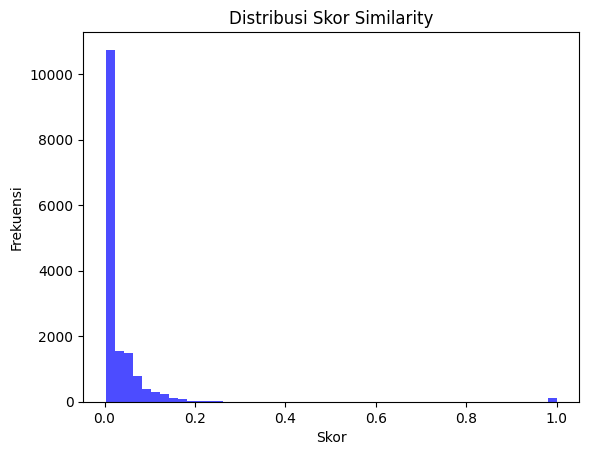


🎯 Contoh rekomendasi untuk: Blue Lagoon Jogja (ID: 127)


,Similarity_Score,Place_Id,Place_Name,Category,Rating,Price
68,0.211678,203,Galaxy Waterpark Jogja,Taman Hiburan,4.3,40000
3,0.171507,103,Tugu Pal Putih Jogja,Taman Hiburan,4.7,0
22,0.156561,134,Desa Wisata Gamplong,Taman Hiburan,4.4,10000
49,0.151197,130,Studio Alam Gamplong,Taman Hiburan,4.4,10000
95,0.147297,136,Grojogan Watu Purbo Bangunrejo,Taman Hiburan,4.5,10000



📊 Fallback: Top Rating


,Place_Id,Place_Name,Category,Rating,Price
94,124,Kauman Pakualaman Yogyakarta,Budaya,5.0,0
54,95,Desa Wisata Sungai Code Jogja Kota,Taman Hiburan,5.0,0
120,106,Kawasan Malioboro,Taman Hiburan,4.8,0
35,92,Nol Kilometer Jl.Malioboro,Taman Hiburan,4.7,0
103,161,"Bukit Paralayang, Watugupit",Cagar Alam,4.7,5000



💸 Fallback: Best Value for Money


,Place_Id,Place_Name,Category,Rating,Price,Value_Score
54,95,Desa Wisata Sungai Code Jogja Kota,Taman Hiburan,5.0,0,5.0
94,124,Kauman Pakualaman Yogyakarta,Budaya,5.0,0,5.0
120,106,Kawasan Malioboro,Taman Hiburan,4.8,0,4.8
3,103,Tugu Pal Putih Jogja,Taman Hiburan,4.7,0,4.7
35,92,Nol Kilometer Jl.Malioboro,Taman Hiburan,4.7,0,4.7



💾 Model tersimpan di: ../Model/jogja_recommender.joblib


In [4]:
# %%
import pandas as pd
import numpy as np
import ast
import joblib
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# %%
# Load data
try:
    df = pd.read_csv('../Datasets/DatasetTouris.csv')
    print("✅ Dataset loaded successfully")
    print(f"Total records: {len(df)}")
    print("Columns available:", df.columns.tolist())
except FileNotFoundError:
    print("❌ Error: File not found.")
    print("Current working directory:", os.getcwd())

# %%
# Stopwords
stopwords_indonesia = [
    'yang', 'di', 'ke', 'dari', 'dan', 'untuk', 'pada', 'dengan', 'ini', 'itu',
    'atau', 'juga', 'dalam', 'tidak', 'akan', 'ada', 'oleh', 'karena', 'bisa'
]

# Filter untuk Jogja
if 'City' in df.columns:
    df_jogja = df[df['City'].str.contains('yogyakarta|diy', case=False, na=False)].copy()

    # Isi NaN
    df_jogja['Category'] = df_jogja['Category'].fillna('Umum')
    df_jogja['Price'] = df_jogja['Price'].fillna(0)

    # Hapus duplikat destinasi berdasarkan Place_Id
    df_jogja = df_jogja.drop_duplicates(subset='Place_Id').reset_index(drop=True)
    print(f"\n🔍 Data Jogja ditemukan: {len(df_jogja)} destinasi")

    # Composite features
    df_jogja['Composite_Features'] = (
        df_jogja['Place_Name'] + ' ' +
        df_jogja['Category'] + ' ' +
        df_jogja['Rating'].astype(str) + ' ' +
        df_jogja['Price'].astype(str) + ' ' +
        df_jogja['Coordinate'].apply(
            lambda x: str(ast.literal_eval(x)['lat']) + ' ' + str(ast.literal_eval(x)['lng'])
        )
    )
    print("✅ Composite features berhasil dibuat")

else:
    print("❌ Kolom 'City' tidak ditemukan.")

# %%
# TF-IDF & Similarity
if not df_jogja.empty:
    tfidf = TfidfVectorizer(
        stop_words=stopwords_indonesia,
        ngram_range=(1, 2),
        max_features=1000
    )
    tfidf_matrix = tfidf.fit_transform(df_jogja['Composite_Features'])
    cosine_sim = cosine_similarity(tfidf_matrix)
    print(f"✅ TF-IDF shape: {tfidf_matrix.shape}")

    # Visualisasi distribusi similarity
    plt.hist(cosine_sim.flatten(), bins=50, alpha=0.7, color='blue')
    plt.title('Distribusi Skor Similarity')
    plt.xlabel('Skor')
    plt.ylabel('Frekuensi')
    plt.show()

# %%
# Fungsi rekomendasi utama
def rekomendasi_jogja(place_id, max_results=5):
    try:
        if place_id not in df_jogja['Place_Id'].values:
            print("📊 Fallback: Top Rating")
            top_rating = df_jogja.sort_values(by='Rating', ascending=False).head(max_results)
            return top_rating[['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price']]

        idx = df_jogja.index[df_jogja['Place_Id'] == place_id].tolist()[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:max_results+1]

        recommendations = df_jogja.iloc[[i[0] for i in sim_scores]][
            ['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price']
        ]
        recommendations.insert(0, 'Similarity_Score', [i[1] for i in sim_scores])

        return recommendations

    except Exception as e:
        return f"🚨 Error: {str(e)}"

# %%
# Fallback: Top Rating
def fallback_top_rating(n=5):
    return df_jogja.sort_values(by='Rating', ascending=False).head(n)[
        ['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price']
    ]

# %%
# Fallback: Value for Money
def fallback_best_value(n=5):
    df_val = df_jogja.copy()
    df_val['Value_Score'] = df_val.apply(
        lambda x: x['Rating'] / np.log1p(x['Price']) if x['Price'] > 0 else x['Rating'],
        axis=1
    )
    return df_val.sort_values(by='Value_Score', ascending=False).head(n)[
        ['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price', 'Value_Score']
    ]

# %%
# Contoh rekomendasi
if not df_jogja.empty:
    sample = df_jogja.sample(1)
    place_id = sample['Place_Id'].values[0]
    place_name = sample['Place_Name'].values[0]
    print(f"\n🎯 Contoh rekomendasi untuk: {place_name} (ID: {place_id})")
    display(rekomendasi_jogja(place_id))

    print("\n📊 Fallback: Top Rating")
    display(fallback_top_rating())

    print("\n💸 Fallback: Best Value for Money")
    display(fallback_best_value())

    # Save model
    joblib.dump(
        {
            'tfidf': tfidf,
            'cosine_sim': cosine_sim,
            'place_ids': df_jogja['Place_Id'].tolist()
        },
        '../Model/jogja_recommender.joblib'
    )
    print("\n💾 Model tersimpan di: ../Model/jogja_recommender.joblib")
